Loading data...
  Processing historical...
  Processing ssp126...
  Processing ssp245...
  Processing ssp585...
  Processing g6sulfur...
Data loading complete!


/tmp/ipykernel_104606/3784893225.py:237: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1.0, 1.0], h_pad=1.0, w_pad=0.5)



Figure saved to: ../Figures/fig4_01.png


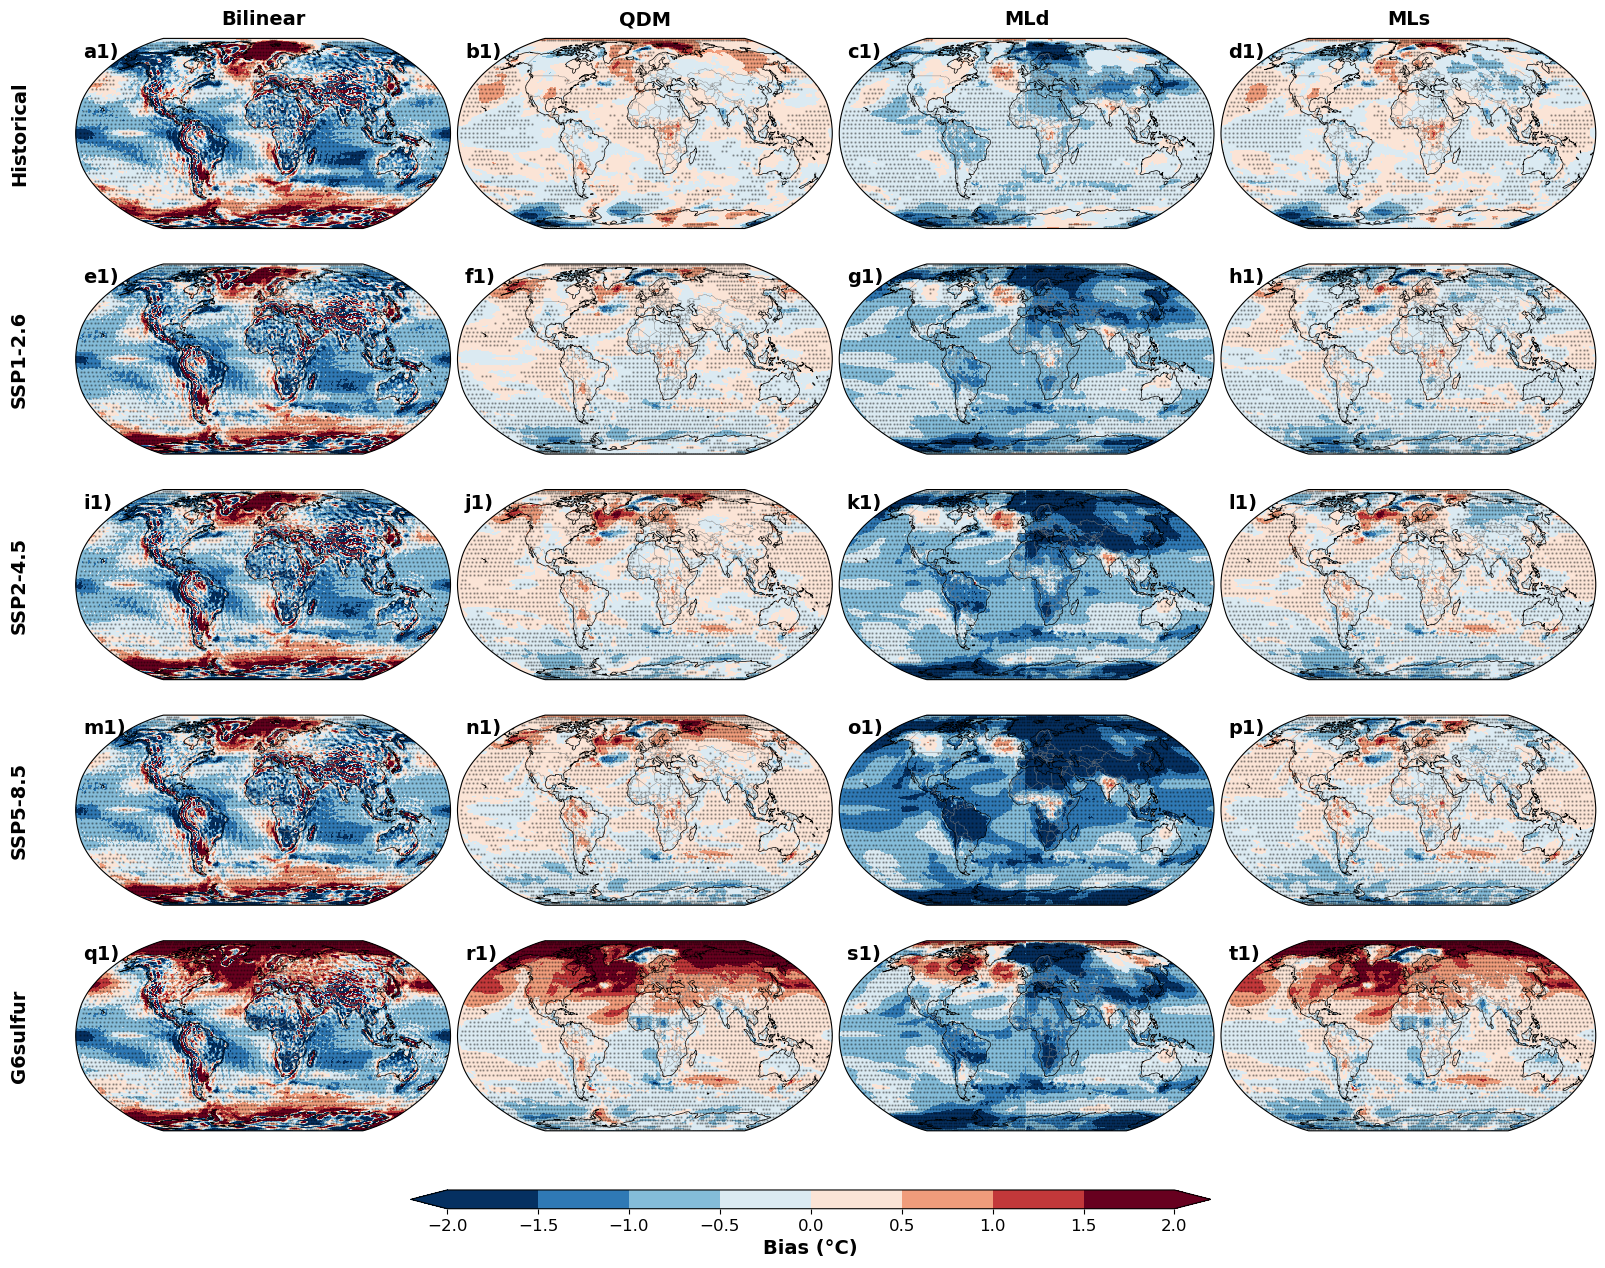

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from scipy import stats

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

var_name = 'tas'
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585', 'g6sulfur']
scenario_labels = {
    'historical': 'Historical',
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5',
    'g6sulfur': 'G6sulfur'
}

# Model configuration
models = ['bilinear', 'qdm', 'mld', 'mls']
model_labels = {
    'bilinear': 'Bilinear',
    'qdm': 'QDM',
    'mld': 'MLd',
    'mls': 'MLs'
}

# Significance level
alpha = 0.05  # 95% confidence level

# ----------------------------
# Functions
# ----------------------------
def shift_data_longitude(data, lon):
    """
    Shift data and longitude from [0, 360] to [-180, 180].
    Works for uniform longitude spacing.
    
    Args:
        data: numpy array with shape (time, lat, lon) or (lat, lon)
        lon: 1D longitude array in [0, 360]
    
    Returns:
        data_shifted: data array with longitude rolled
        lon_shifted: longitude array in [-180, 180]
    """
    # Convert longitude to [-180, 180]
    lon_shifted = np.where(lon > 180, lon - 360, lon)
    
    # Find the index where original lon crosses 180
    split_idx = np.searchsorted(lon, 180.0)
    
    # Roll the data so that -180 comes first
    if data.ndim == 2:
        # 2D data (lat, lon)
        data_shifted = np.roll(data, -split_idx, axis=1)
    elif data.ndim == 3:
        # 3D data (time, lat, lon)
        data_shifted = np.roll(data, -split_idx, axis=2)
    else:
        raise ValueError(f"Unexpected data dimensions: {data.ndim}")
    
    # Also roll the longitude array
    lon_shifted = np.roll(lon_shifted, -split_idx)
    
    return data_shifted, lon_shifted

def calculate_mean_bias(pred_data, truth_data):
    """Calculate mean bias (prediction - truth) over all time steps."""
    bias = pred_data - truth_data
    mean_bias = np.mean(bias, axis=0)
    return mean_bias

def calculate_significance(pred_data, truth_data, alpha=0.05):
    """
    Calculate statistical significance of bias using t-test.
    Returns a boolean mask where True indicates significant bias.
    """
    # Calculate bias for each time step
    bias = pred_data - truth_data  # shape: (time, lat, lon)
    
    # Perform one-sample t-test at each grid point
    # H0: mean bias = 0
    t_stat, p_values = stats.ttest_1samp(bias, 0, axis=0)
    
    # Significant where p-value < alpha
    significant = p_values < alpha
    
    return significant

# ----------------------------
# Load data and calculate biases
# ----------------------------
print("Loading data...")
biases = {scenario: {} for scenario in scenarios}
significance = {scenario: {} for scenario in scenarios}
lat, lon = None, None
lon_original = None

for scenario in scenarios:
    print(f"  Processing {scenario}...")
    
    # Load main results (for groundtruth, bilinear, MLd)
    main_file = results_dir / f"{var_name}_evaluation_{scenario}.nc"
    ds_main = xr.open_dataset(main_file)
    
    if lat is None:
        lat = ds_main.lat.values
        lon_original = ds_main.lon.values
    
    # Shift truth data
    truth, lon = shift_data_longitude(ds_main['groundtruth'].values, lon_original)
    
    # Bilinear bias
    if 'input' in ds_main:
        input_data, _ = shift_data_longitude(ds_main['input'].values, lon_original)
        biases[scenario]['bilinear'] = calculate_mean_bias(input_data, truth)
        significance[scenario]['bilinear'] = calculate_significance(input_data, truth, alpha)
    
    # MLd bias (zscore_pixel)
    if 'pred_zscore_pixel' in ds_main:
        mld_data, _ = shift_data_longitude(ds_main['pred_zscore_pixel'].values, lon_original)
        biases[scenario]['mld'] = calculate_mean_bias(mld_data, truth)
        significance[scenario]['mld'] = calculate_significance(mld_data, truth, alpha)
    
    ds_main.close()
    
    # Load QDM results
    qdm_file = results_dir / f"{var_name}_evaluation_{scenario}_qdm.nc"
    if qdm_file.exists():
        ds_qdm = xr.open_dataset(qdm_file)
        
        if 'pred_qdm' in ds_qdm:
            qdm_data, _ = shift_data_longitude(ds_qdm['pred_qdm'].values, lon_original)
            truth_qdm, _ = shift_data_longitude(ds_qdm['groundtruth'].values, lon_original)
            biases[scenario]['qdm'] = calculate_mean_bias(qdm_data, truth_qdm)
            significance[scenario]['qdm'] = calculate_significance(qdm_data, truth_qdm, alpha)
        
        ds_qdm.close()
    
    # Load residual results (for MLs)
    residual_file = results_residual_dir / f"{var_name}_evaluation_{scenario}.nc"
    if residual_file.exists():
        ds_residual = xr.open_dataset(residual_file)
        
        if 'pred_grid' in ds_residual:
            mls_data, _ = shift_data_longitude(ds_residual['pred_grid'].values, lon_original)
            truth_res, _ = shift_data_longitude(ds_residual['groundtruth'].values, lon_original)
            biases[scenario]['mls'] = calculate_mean_bias(mls_data, truth_res)
            significance[scenario]['mls'] = calculate_significance(mls_data, truth_res, alpha)
        
        ds_residual.close()

print("Data loading complete!")

# ----------------------------
# Create 5x4 subplot figure
# ----------------------------
fig = plt.figure(figsize=(16, 12.5))

# Colormap settings
cmap = 'RdBu_r'
bias_vmin, bias_vmax = -2, 2
bias_levels = np.linspace(bias_vmin, bias_vmax, 9)
bias_norm = BoundaryNorm(bias_levels, ncolors=256)

# Panel labels
panel_labels = [f"{chr(97 + i)}1)" for i in range(20)]

# Create meshgrid for plotting
lon_2d, lat_2d = np.meshgrid(lon, lat)

# Plot 5 rows (scenarios) x 4 columns (models)
for row_idx, scenario in enumerate(scenarios):
    for col_idx, model in enumerate(models):
        ax = fig.add_subplot(5, 4, row_idx * 4 + col_idx + 1, projection=ccrs.Robinson())
        
        bias = biases[scenario][model]
        sig = significance[scenario][model]
        
        # Plot bias
        im = ax.pcolormesh(lon_2d, lat_2d, bias,
                          transform=ccrs.PlateCarree(),
                          cmap=cmap, norm=bias_norm,
                          shading='auto')
        
        # Add stippling for significant areas
        # Subsample for better visualization (every 4th point)
        lat_sub = lat[::4]
        lon_sub = lon[::4]
        sig_sub = sig[::4, ::4]
        lon_sub_2d, lat_sub_2d = np.meshgrid(lon_sub, lat_sub)
        
        # Plot dots where significant
        ax.scatter(lon_sub_2d[sig_sub], lat_sub_2d[sig_sub],
                  s=0.5, c='black', alpha=0.3,
                  transform=ccrs.PlateCarree(),
                  rasterized=True)
        
        ax.coastlines(linewidth=0.5, color='black')
        ax.add_feature(cfeature.BORDERS, linewidth=0.3, edgecolor='gray')
        ax.set_global()
        
        # Column title (top row only)
        if row_idx == 0:
            ax.set_title(model_labels[model], fontsize=14, fontweight='bold', pad=10)
        
        # Scenario label on left (first column only)
        if col_idx == 0:
            ax.text(-0.15, 0.5, scenario_labels[scenario], 
                   transform=ax.transAxes,
                   fontsize=14, fontweight='bold',
                   rotation=90, va='center', ha='center')
        
        # Panel label
        ax.text(0.02, 0.98, panel_labels[row_idx * 4 + col_idx], 
               transform=ax.transAxes,
               fontsize=14, fontweight='bold',
               verticalalignment='top',
               color='black')

# Add colorbar
cbar_ax = fig.add_axes([0.25, 0.02, 0.5, 0.015])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('Bias (°C)', fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1.0, 1.0], h_pad=1.0, w_pad=0.5)

# Save figure
output_file = figures_dir / "fig4_01.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\nFigure saved to: {output_file}")
plt.show()

Loading data...
  Loaded historical
  Loaded ssp126
  Loaded ssp245
  Loaded ssp585
  Loaded g6sulfur


/tmp/ipykernel_104606/4228019049.py:185: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1.0, 1.0], h_pad=1.0, w_pad=0.5)


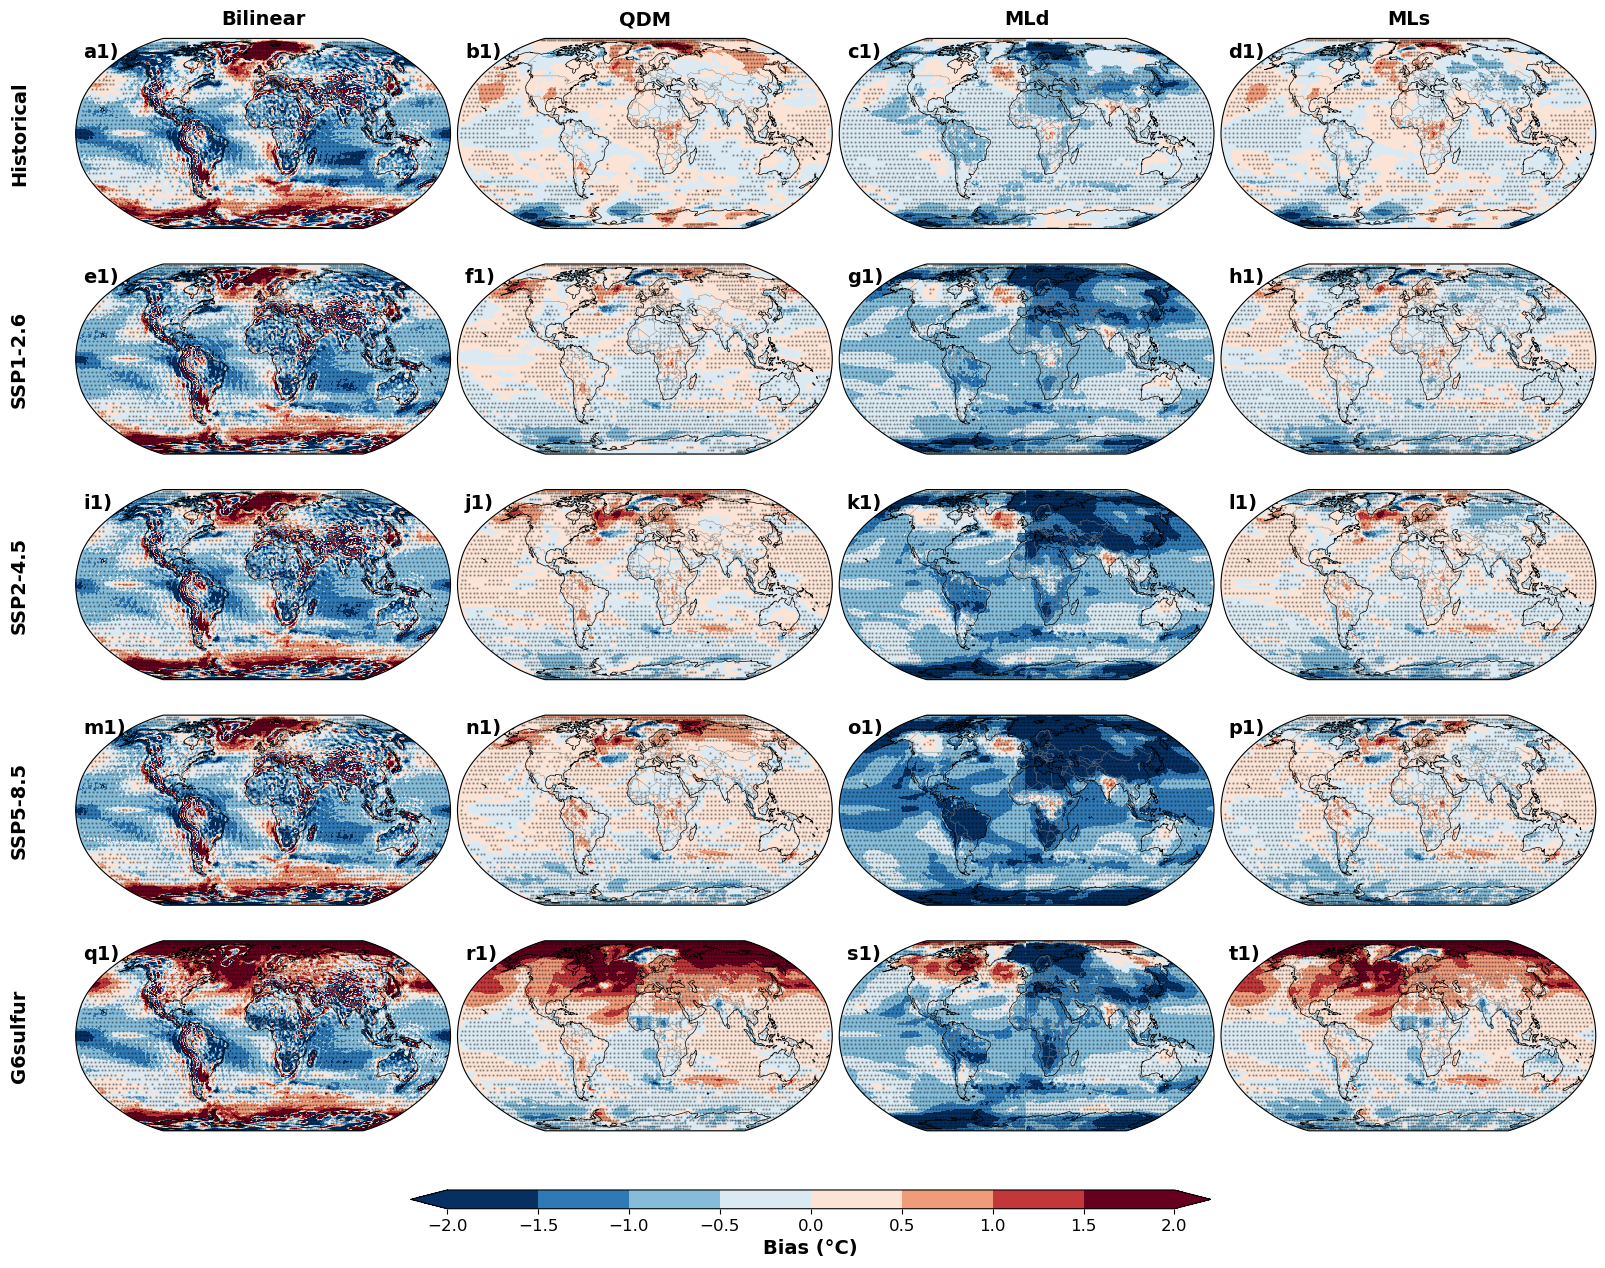

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from scipy import stats

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

var_name = 'tas'
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585', 'g6sulfur']
scenario_labels = {
    'historical': 'Historical',
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5',
    'g6sulfur': 'G6sulfur'
}

# Model configuration
models = ['bilinear', 'qdm', 'mld', 'mls']
model_labels = {
    'bilinear': 'Bilinear',
    'qdm': 'QDM',
    'mld': 'MLd',
    'mls': 'MLs'
}

# Significance level
alpha = 0.05  # 95% confidence level

# ----------------------------
# Functions
# ----------------------------
def calculate_mean_bias(pred_data, truth_data):
    """Calculate mean bias (prediction - truth) over all time steps."""
    bias = pred_data - truth_data
    mean_bias = np.mean(bias, axis=0)
    return mean_bias

def calculate_significance(pred_data, truth_data, alpha=0.05):
    """
    Calculate statistical significance of bias using t-test.
    Returns a boolean mask where True indicates significant bias.
    """
    # Calculate bias for each time step
    bias = pred_data - truth_data  # shape: (time, lat, lon)
    
    # Perform one-sample t-test at each grid point
    # H0: mean bias = 0
    t_stat, p_values = stats.ttest_1samp(bias, 0, axis=0)
    
    # Significant where p-value < alpha
    significant = p_values < alpha
    
    return significant

# ----------------------------
# Load data and calculate biases
# ----------------------------
print("Loading data...")
biases = {scenario: {} for scenario in scenarios}
significance = {scenario: {} for scenario in scenarios}
lat, lon = None, None

for scenario in scenarios:
    # Load main results (for groundtruth, bilinear, MLd)
    main_file = results_dir / f"{var_name}_evaluation_{scenario}.nc"
    ds_main = xr.open_dataset(main_file)
    
    truth = ds_main['groundtruth'].values
    
    if lat is None:
        lat = ds_main.lat.values
        lon = ds_main.lon.values
    
    # Bilinear bias
    if 'input' in ds_main:
        biases[scenario]['bilinear'] = calculate_mean_bias(ds_main['input'].values, truth)
        significance[scenario]['bilinear'] = calculate_significance(ds_main['input'].values, truth, alpha)
    
    # MLd bias (zscore_pixel)
    if 'pred_zscore_pixel' in ds_main:
        biases[scenario]['mld'] = calculate_mean_bias(ds_main['pred_zscore_pixel'].values, truth)
        significance[scenario]['mld'] = calculate_significance(ds_main['pred_zscore_pixel'].values, truth, alpha)
    
    # Load QDM results
    qdm_file = results_dir / f"{var_name}_evaluation_{scenario}_qdm.nc"
    if qdm_file.exists():
        ds_qdm = xr.open_dataset(qdm_file)
        if 'pred_qdm' in ds_qdm:
            biases[scenario]['qdm'] = calculate_mean_bias(ds_qdm['pred_qdm'].values, truth)
            significance[scenario]['qdm'] = calculate_significance(ds_qdm['pred_qdm'].values, truth, alpha)
    
    # Load residual results (for MLs)
    residual_file = results_residual_dir / f"{var_name}_evaluation_{scenario}.nc"
    if residual_file.exists():
        ds_residual = xr.open_dataset(residual_file)
        if 'pred_grid' in ds_residual:
            biases[scenario]['mls'] = calculate_mean_bias(ds_residual['pred_grid'].values, truth)
            significance[scenario]['mls'] = calculate_significance(ds_residual['pred_grid'].values, truth, alpha)
    
    print(f"  Loaded {scenario}")

# ----------------------------
# Create 5x4 subplot figure
# ----------------------------
fig = plt.figure(figsize=(16, 12.5))

# Colormap settings
cmap = 'RdBu_r'
bias_vmin, bias_vmax = -2, 2
bias_levels = np.linspace(bias_vmin, bias_vmax, 9)
bias_norm = BoundaryNorm(bias_levels, ncolors=256)

# Panel labels
panel_labels = [f"{chr(97 + i)}1)" for i in range(20)]

# Create meshgrid for plotting
lon_2d, lat_2d = np.meshgrid(lon, lat)

# Plot 5 rows (scenarios) x 4 columns (models)
for row_idx, scenario in enumerate(scenarios):
    for col_idx, model in enumerate(models):
        ax = fig.add_subplot(5, 4, row_idx * 4 + col_idx + 1, projection=ccrs.Robinson())
        
        bias = biases[scenario][model]
        sig = significance[scenario][model]
        
        # Plot bias
        im = ax.pcolormesh(lon_2d, lat_2d, bias,
                          transform=ccrs.PlateCarree(),
                          cmap=cmap, norm=bias_norm,
                          shading='auto')
        
        # Add stippling for significant areas
        # Subsample for better visualization (every 4th point)
        lat_sub = lat[::4]
        lon_sub = lon[::4]
        sig_sub = sig[::4, ::4]
        lon_sub_2d, lat_sub_2d = np.meshgrid(lon_sub, lat_sub)
        
        # Plot dots where significant
        ax.scatter(lon_sub_2d[sig_sub], lat_sub_2d[sig_sub],
                  s=0.5, c='black', alpha=0.3,
                  transform=ccrs.PlateCarree(),
                  rasterized=True)
        
        ax.coastlines(linewidth=0.5, color='black')
        ax.add_feature(cfeature.BORDERS, linewidth=0.3, edgecolor='gray')
        ax.set_global()
        
        # Column title (top row only)
        if row_idx == 0:
            ax.set_title(model_labels[model], fontsize=14, fontweight='bold', pad=10)
        
        # Scenario label on left (first column only)
        if col_idx == 0:
            ax.text(-0.15, 0.5, scenario_labels[scenario], 
                   transform=ax.transAxes,
                   fontsize=14, fontweight='bold',
                   rotation=90, va='center', ha='center')
        
        # Panel label
        ax.text(0.02, 0.98, panel_labels[row_idx * 4 + col_idx], 
               transform=ax.transAxes,
               fontsize=14, fontweight='bold',
               verticalalignment='top',
               color='black')

# Add colorbar
cbar_ax = fig.add_axes([0.25, 0.02, 0.5, 0.015])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('Bias (°C)', fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1.0, 1.0], h_pad=1.0, w_pad=0.5)

# Save figure
output_file = figures_dir / "fig4_01.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

Loading data...
  Loaded historical
  Loaded ssp126
  Loaded ssp245
  Loaded ssp585
  Loaded g6sulfur

Calculating zonal mean biases...

Figure saved to: ../Figures/fig4_02.png


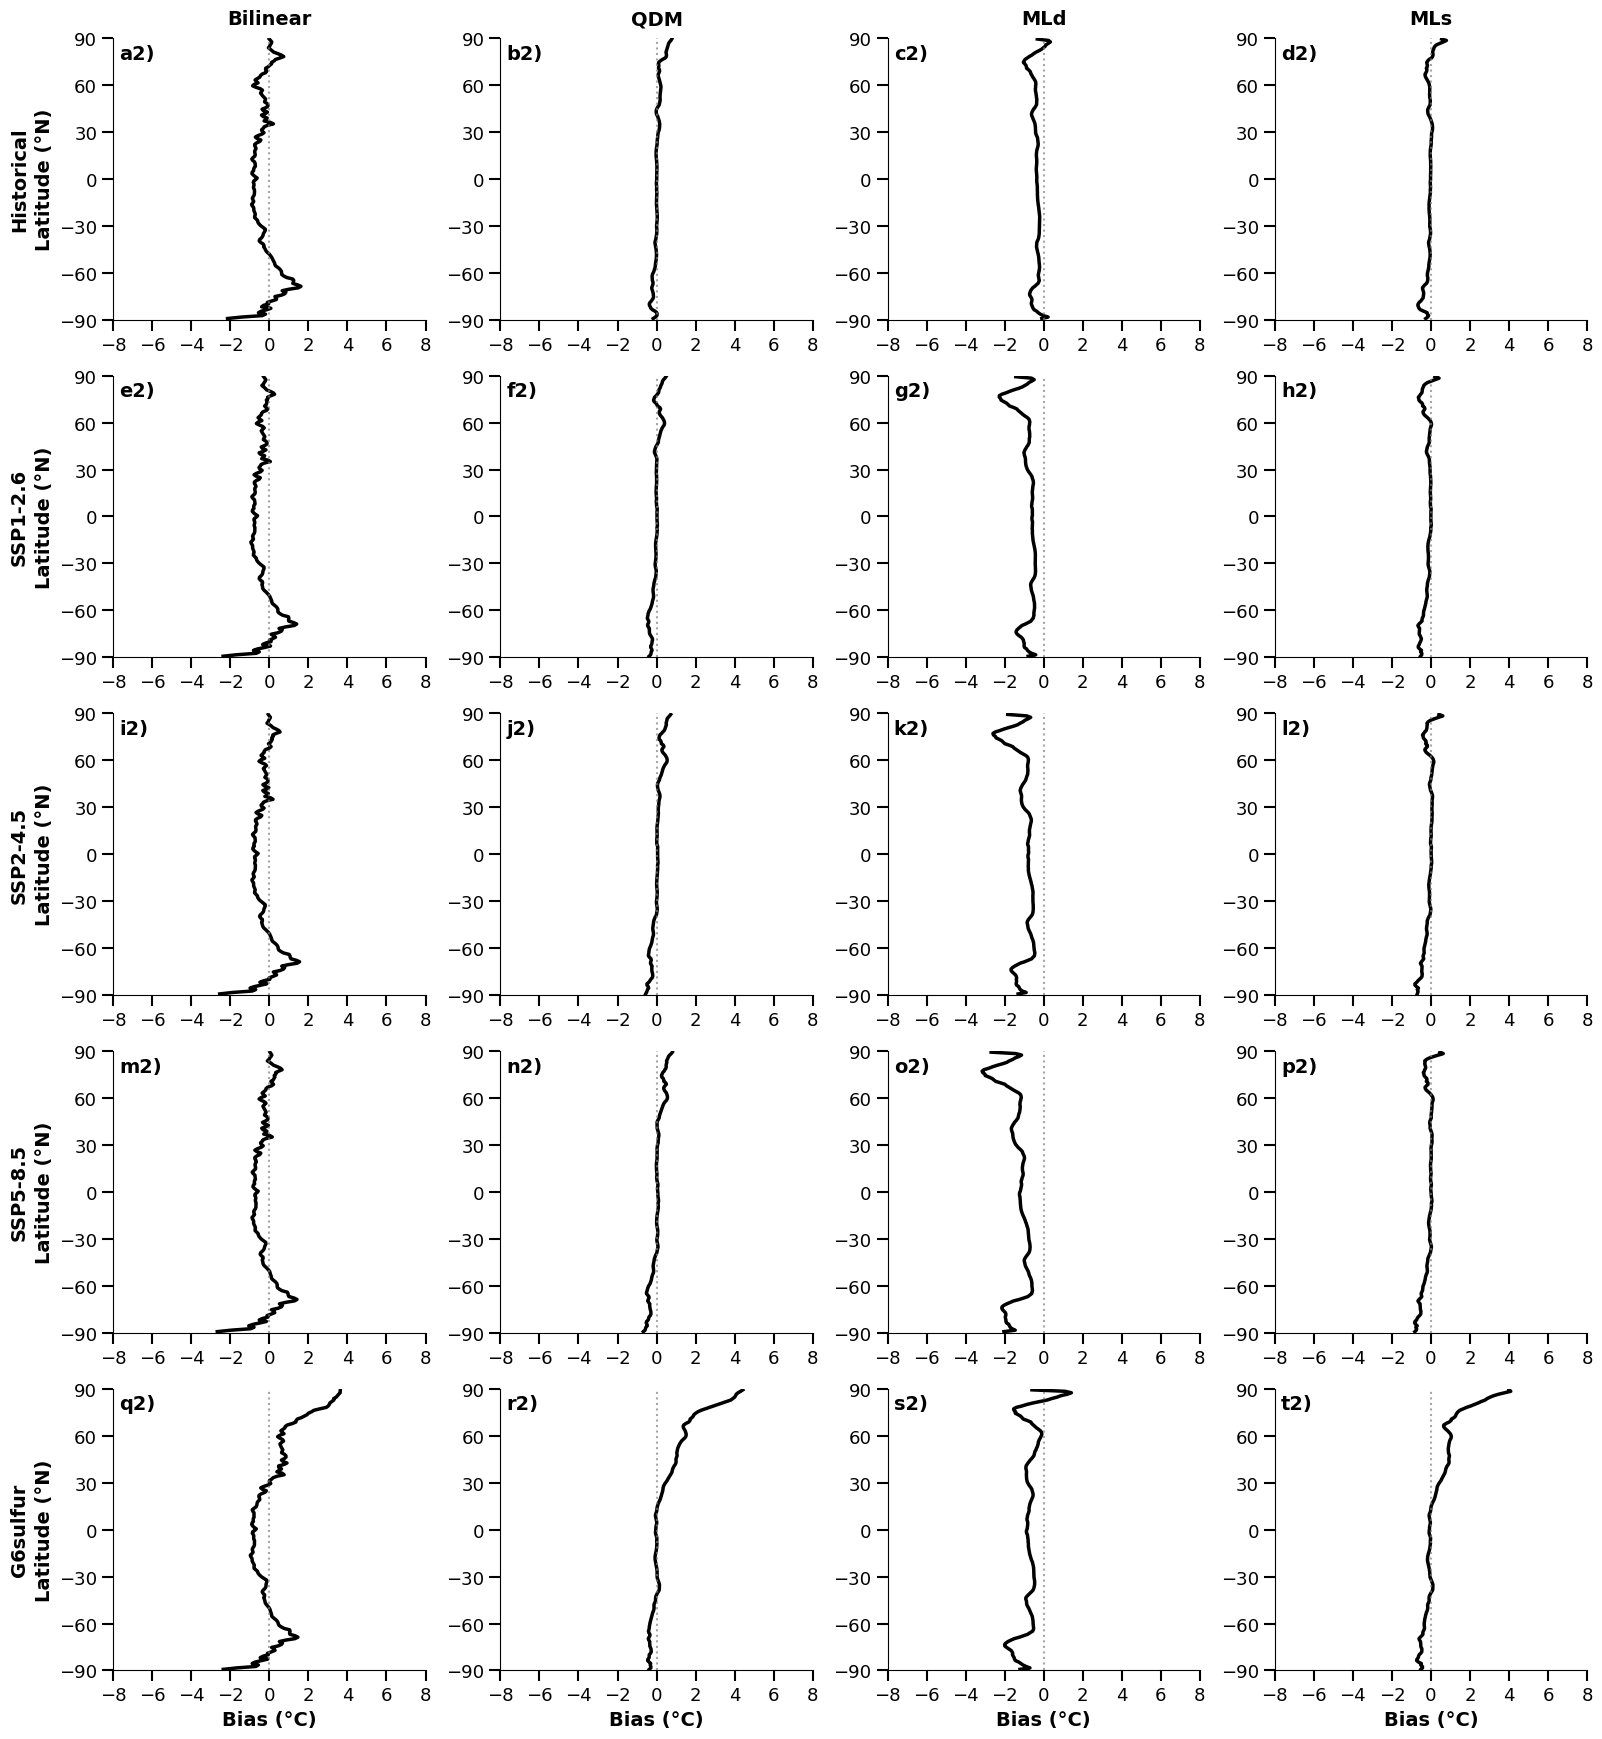

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import warnings

# Suppress warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

var_name = 'tas'
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585', 'g6sulfur'] 
scenario_labels = {
    'historical': 'Historical',  
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5',
    'g6sulfur': 'G6sulfur'
}

# Model configuration
models = ['bilinear', 'qdm', 'mld', 'mls']
model_labels = {
    'bilinear': 'Bilinear',
    'qdm': 'QDM',
    'mld': 'MLd',
    'mls': 'MLs'
}

# ----------------------------
# Helper Functions
# ----------------------------
def calculate_mean_bias(pred_data, truth_data):
    """Calculate mean bias over all time steps."""
    bias = pred_data - truth_data
    mean_bias = np.mean(bias, axis=0)
    return mean_bias

def compute_zonal_mean_bias(bias_2d):
    """Compute zonal mean (longitude average)."""
    zonal_mean = np.nanmean(bias_2d, axis=1)
    return zonal_mean

# ----------------------------
# Load data and calculate biases
# ----------------------------
print("Loading data...")
biases = {scenario: {} for scenario in scenarios}
lat = None

for scenario in scenarios:
    # Load main results (for groundtruth, bilinear, MLd)
    main_file = results_dir / f"{var_name}_evaluation_{scenario}.nc"
    ds_main = xr.open_dataset(main_file)
    
    truth = ds_main['groundtruth'].values
    
    if lat is None:
        lat = ds_main.lat.values
    
    # Bilinear bias
    if 'input' in ds_main:
        biases[scenario]['bilinear'] = calculate_mean_bias(ds_main['input'].values, truth)
    
    # MLd bias (zscore_pixel)
    if 'pred_zscore_pixel' in ds_main:
        biases[scenario]['mld'] = calculate_mean_bias(ds_main['pred_zscore_pixel'].values, truth)
    
    # Load QDM results
    qdm_file = results_dir / f"{var_name}_evaluation_{scenario}_qdm.nc"
    if qdm_file.exists():
        ds_qdm = xr.open_dataset(qdm_file)
        if 'pred_qdm' in ds_qdm:
            biases[scenario]['qdm'] = calculate_mean_bias(ds_qdm['pred_qdm'].values, truth)
    
    # Load residual results (for MLs)
    residual_file = results_residual_dir / f"{var_name}_evaluation_{scenario}.nc"
    if residual_file.exists():
        ds_residual = xr.open_dataset(residual_file)
        if 'pred_grid' in ds_residual:
            biases[scenario]['mls'] = calculate_mean_bias(ds_residual['pred_grid'].values, truth)
    
    print(f"  Loaded {scenario}")

# ----------------------------
# Calculate zonal means
# ----------------------------
print("\nCalculating zonal mean biases...")
zonal_results = {scenario: {} for scenario in scenarios}

for scenario in scenarios:
    for model in models:
        zonal_results[scenario][model] = compute_zonal_mean_bias(biases[scenario][model])

# ----------------------------
# Create 5x4 subplot figure 
# ----------------------------
fig, axes = plt.subplots(5, 4, figsize=(16, 17.5))

for row_idx, scenario in enumerate(scenarios):
    for col_idx, model in enumerate(models):
        ax = axes[row_idx, col_idx]
        
        # Plot zonal mean bias (black solid line)
        ax.plot(zonal_results[scenario][model], lat, 
                color='black', linewidth=2.5, linestyle='-')
        
        # Add vertical line at x=0
        ax.axvline(x=0, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
        
        # Formatting
        ax.set_ylim(-90, 90)
        ax.set_yticks(np.arange(-90, 91, 30))
        ax.set_xlim(-8, 8)
        ax.set_xticks(np.arange(-8, 9, 2))
        
        ax.tick_params(axis='both', which='major', labelsize=13, 
                      length=8, width=1.5)
        
        # Labels
        if row_idx == 4:  # Bottom row (changed from 3)
            ax.set_xlabel('Bias (°C)', fontsize=14, fontweight='bold')
        
        if col_idx == 0:  # Left column
            ax.set_ylabel('Latitude (°N)', fontsize=14, fontweight='bold')
        
        # Title for top row (model names)
        if row_idx == 0:
            ax.set_title(model_labels[model], fontsize=14, fontweight='bold', pad=10)
        
        # Scenario label on left side (first column only)
        if col_idx == 0:
            ax.text(-0.3, 0.5, scenario_labels[scenario], 
                   transform=ax.transAxes,
                   fontsize=14, fontweight='bold',
                   rotation=90, va='center', ha='center')
        
        # Add panel label
        panel_label = chr(97 + row_idx * 4 + col_idx) + '2)'
        ax.text(0.02, 0.98, panel_label, 
               transform=ax.transAxes,
               fontsize=14, fontweight='bold',
               verticalalignment='top')
        
        # Spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

plt.tight_layout()
output_file = figures_dir / "fig4_02.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\nFigure saved to: {output_file}")
plt.show()